In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('Churn_Modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
df['HasCrCard']=df['HasCrCard'].astype(bool)
df['IsActiveMember']=df['IsActiveMember'].astype(bool)
df['Exited']=df['Exited'].astype(bool)

In [12]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box Plot of Balance')

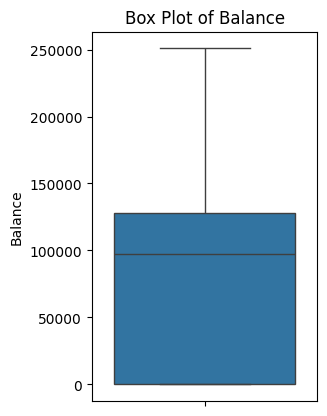

In [15]:
plt.subplot(1, 2, 1)
sns.boxplot(y=df["Balance"])
plt.title("Box Plot of Balance")

Text(0.5, 1.0, 'Box Plot of EstimatedSalary')

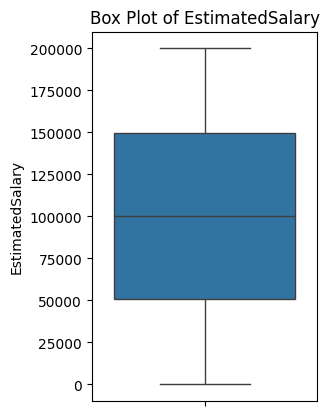

In [16]:
plt.subplot(1, 2, 2)
sns.boxplot(y=df["EstimatedSalary"])
plt.title("Box Plot of EstimatedSalary")

In [21]:
df['Balance'].describe()

,Balance
count,10000.000000
mean,76485.889288
std,62397.405202
min,0.000000
25%,0.000000
50%,97198.540000
75%,127644.240000
max,250898.090000


In [22]:
df['EstimatedSalary'].describe()

,EstimatedSalary
count,10000.000000
mean,100090.239881
std,57510.492818
min,11.580000
25%,51002.110000
50%,100193.915000
75%,149388.247500
max,199992.480000


In [19]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers


In [20]:
balance_outliers = detect_outliers_iqr(df, "Balance")
salary_outliers = detect_outliers_iqr(df, "EstimatedSalary")

print(f"Outliers in Balance: {len(balance_outliers)}")
print(f"Outliers in EstimatedSalary: {len(salary_outliers)}")

Outliers in Balance: 0
Outliers in EstimatedSalary: 0


In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()
df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']])

In [27]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Exited"])  # Features
y = df["Exited"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.865
              precision    recall  f1-score   support

       False       0.88      0.97      0.92      1593
        True       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [31]:
import joblib

y_test_pred = best_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_test_pred))

joblib.dump(best_model, "churn_model.pkl")  # Save trained model

Final Model Accuracy: 0.868


['churn_model.pkl']